In [1]:
import os

import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from scipy.spatial import cKDTree

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_46805/1370252240.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.9,1])


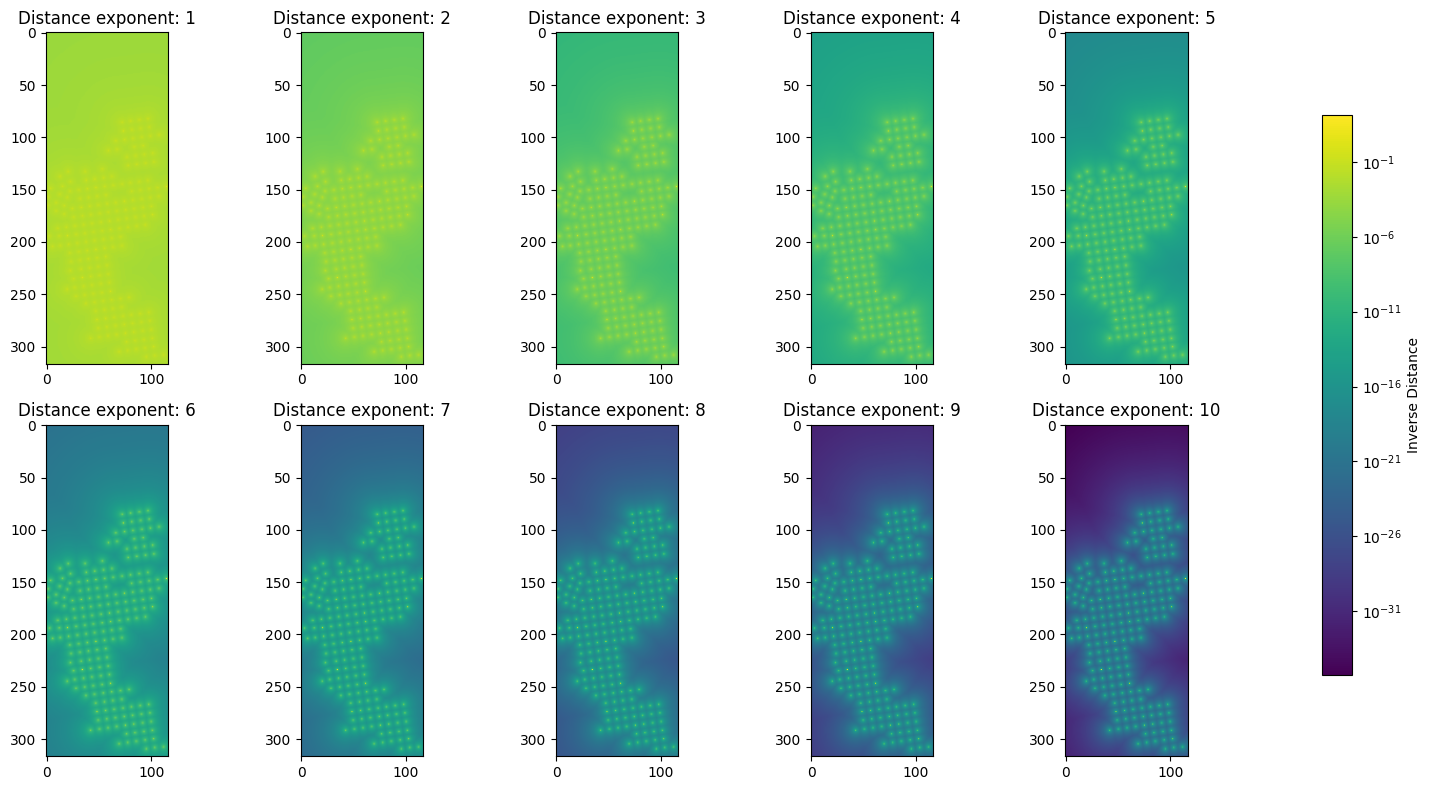

In [3]:

template_path = 'data/raster/rap/woody_cover_1986.tif'

bird_points_path = 'data/vector/2019PointCounts.kml'
proj_crs = 6514

bird_points = gpd.read_file(bird_points_path)
bird_points.to_crs(epsg=proj_crs, inplace=True)

with rasterio.open(template_path) as src:
    template_raster = src.read(1)
    template_transform = src.transform
    template_crs = src.crs

points = bird_points.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
tree = cKDTree(points)

rows, cols = np.indices(template_raster.shape)
x, y = rasterio.transform.xy(template_transform, rows, cols)
coords = np.stack((np.array(x).flatten(), np.array(y).flatten()), axis=1)

distances, _ = tree.query(coords)
distance_raster = distances.reshape(template_raster.shape)

exponents = list(range(1,11))

wt_layers_dir = 'data/raster/wt_layers'
os.makedirs(wt_layers_dir, exist_ok=True)

prefix = 'distmult_'

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Calculate global min/max across all modified distance rasters
all_modified_rasters = []
for exponent in exponents:
    modified_distance_raster = 1 / (distance_raster ** exponent)
    modified_distance_raster[np.isinf(modified_distance_raster)] = 0
    all_modified_rasters.append(modified_distance_raster)

vmin = min(raster[raster > 0].min() for raster in all_modified_rasters)
vmax = max(raster.max() for raster in all_modified_rasters)
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

for i, exponent in enumerate(exponents):
    modified_distance_raster = all_modified_rasters[i]
    
    # Image Plot
    im = axes[i].imshow(modified_distance_raster, cmap='viridis', norm=norm)
    axes[i].set_title(f'Distance exponent: {exponent}')
    
    output_path = os.path.join(wt_layers_dir, prefix + str(exponent) + '.tif')
    output_path = output_path.replace('e1e', 'e1')
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=modified_distance_raster.shape[0],
        width=modified_distance_raster.shape[1],
        count=1,
        dtype=modified_distance_raster.dtype,
        crs=template_crs,
        transform=template_transform
    ) as dst:
        dst.write(modified_distance_raster, 1)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Inverse Distance')

plt.tight_layout(rect=[0,0,0.9,1])
plt.show()
